<a href="https://colab.research.google.com/github/malakmlk/Connect_4_RL/blob/main/DQN_connect_four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class ConnectFourEnv:
    def __init__(self, rows=6, cols=7):
        self.rows = rows
        self.cols = cols
        self.board = np.zeros((rows, cols))
        self.players = [1, 2]
        self.current_player = random.choice(self.players)
        self.num_moves = 0
        self.max_moves = rows * cols

    def reset(self):
        self.board = np.zeros((self.rows, self.cols))
        self.current_player = random.choice(self.players)
        self.num_moves = 0
        return self.board  # Return the initial state (board)

    def get_valid_moves(self):
        return [col for col in range(self.cols) if self.board[0][col] == 0]

    def step(self, action):
        row = 0
        while row < self.rows - 1 and self.board[row + 1][action] == 0:
            row += 1
        self.board[row][action] = self.current_player
        self.num_moves += 1
        done = self.is_win(row, action) or self.num_moves >= self.max_moves
        reward = 1 if self.is_win(row, action) else 0
        if not done:
            self.current_player = self.players[0] if self.current_player == self.players[1] else self.players[1]
        return self.board.copy(), reward, done, {}  # Return the state (board)

    def is_win(self, row, col):
        player = self.board[row][col]
        # check vertical
        if row >= 3 and np.all(self.board[row-3:row+1, col] == player):
            return True
        # check horizontal
        if np.any([np.all(self.board[row, col:col+4] == player) for col in range(self.cols - 3)]):
            return True
        # check diagonal
        if (col >= 3 and row >= 3 and
            np.all(np.diag(self.board[row-3:row+1, col-3:col+1]) == player)):
            return True
        if (col >= 3 and row <= self.rows - 4 and
            np.all(np.diag(np.flipud(self.board[row:row+4, col-3:col+1])) == player)):
            return True
        return False

    def render(self):
        fig, ax = plt.subplots(figsize=(7, 6))
        # Color map: 0 for empty, 1 for player 1 (red), 2 for player 2 (yellow)
        cmap = plt.cm.colors.ListedColormap(['white', 'red', 'yellow'])
        ax.imshow(self.board, cmap=cmap, vmin=0, vmax=2)

        ax.set_xticks(np.arange(self.cols))
        ax.set_yticks(np.arange(self.rows))
        ax.set_xticklabels([str(i) for i in range(self.cols)])
        ax.set_yticklabels([str(i) for i in range(self.rows)])
        ax.set_title("Connect Four Game")
        plt.colorbar(ax.imshow(self.board, cmap=cmap, vmin=0, vmax=2), ax=ax)
        plt.show()

class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, target_update_freq=10):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq  # Frequency of target network update
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)  # Target network
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        self.update_target_network()  # Initialize target network weights

    def update_target_network(self):
        """Copy weights from q_network to target_network."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def choose_action(self, state):
        valid_actions = [i for i in range(self.action_size) if state[0, i] == 0]  # Check for non-full columns
        if random.random() < self.epsilon:
            return random.choice(range(self.action_size))  # Exploration
        else:
            state_tensor = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0)
            q_values = self.q_network(state_tensor).detach().cpu().numpy()
            # Mask invalid actions by setting their Q-values to a very low number
            masked_q_values = [q_values[0][i] if i in valid_actions else -float('inf') for i in range(self.action_size)]
            return int(np.argmax(masked_q_values))  # Exploitation with valid actions only

    def store_experience(self, state, action, reward, next_state, done):
        self.experience = (state, action, reward, next_state, done)

    def train(self, step_count):
        state, action, reward, next_state, done = self.experience
        state_tensor = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state.flatten(), dtype=torch.float32).unsqueeze(0)

        # Get Q values for current state
        q_values = self.q_network(state_tensor)

        # Get target Q values using the target network
        with torch.no_grad():
            next_q_values = self.target_network(next_state_tensor)
            target_value = reward + (1 - done) * self.gamma * torch.max(next_q_values)

        # Update Q value for the taken action
        target = q_values.clone()
        target[0][action] = target_value

        # Calculate loss
        loss = self.loss_fn(q_values, target)

        # Optimize the Q network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network periodically
        if step_count % self.target_update_freq == 0:
            self.update_target_network()

# Main training loop
env = ConnectFourEnv()
state_size = env.rows * env.cols
action_size = env.cols
agent = DQNAgent(state_size, action_size)

num_episodes = 2000
step_count = 0
for episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.train(step_count)
        state = next_state
        step_count += 1

    if episode % 100 == 0:
        print(f"Episode {episode}/{num_episodes} completed")


Episode 0/2000 completed
Episode 100/2000 completed
Episode 200/2000 completed
Episode 300/2000 completed
Episode 400/2000 completed
Episode 500/2000 completed
Episode 600/2000 completed
Episode 700/2000 completed
Episode 800/2000 completed
Episode 900/2000 completed
Episode 1000/2000 completed
Episode 1100/2000 completed
Episode 1200/2000 completed
Episode 1300/2000 completed
Episode 1400/2000 completed
Episode 1500/2000 completed
Episode 1600/2000 completed
Episode 1700/2000 completed
Episode 1800/2000 completed
Episode 1900/2000 completed


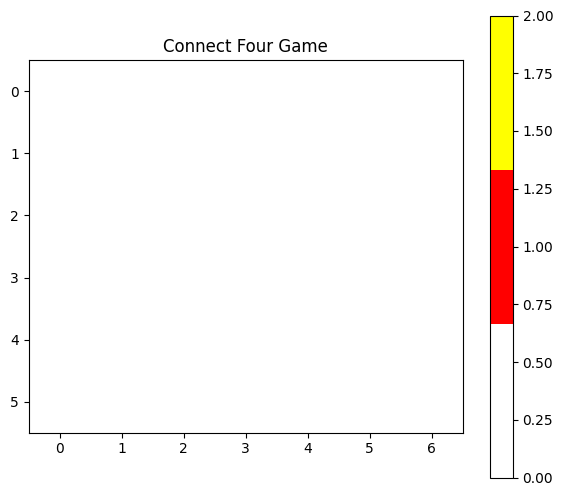

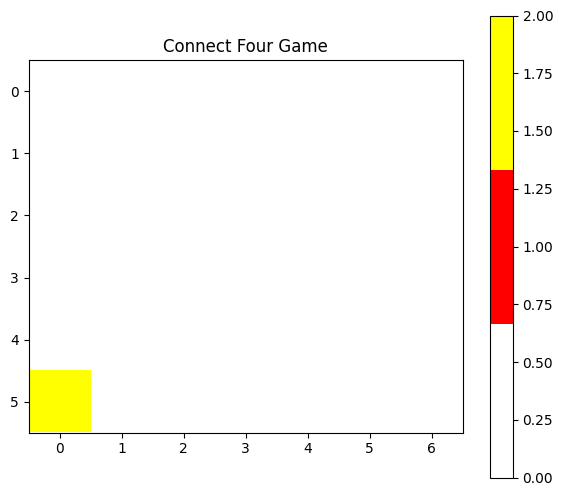

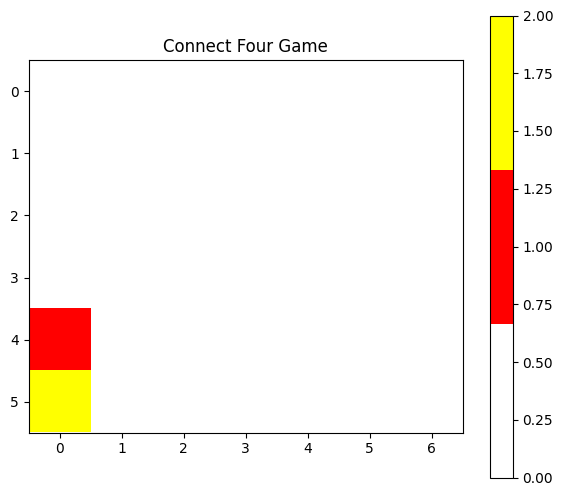

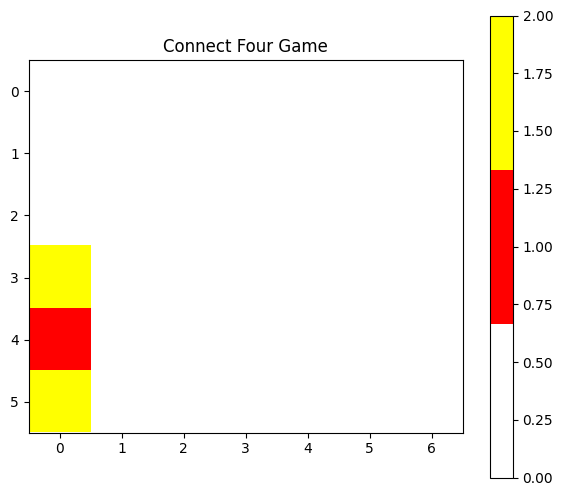

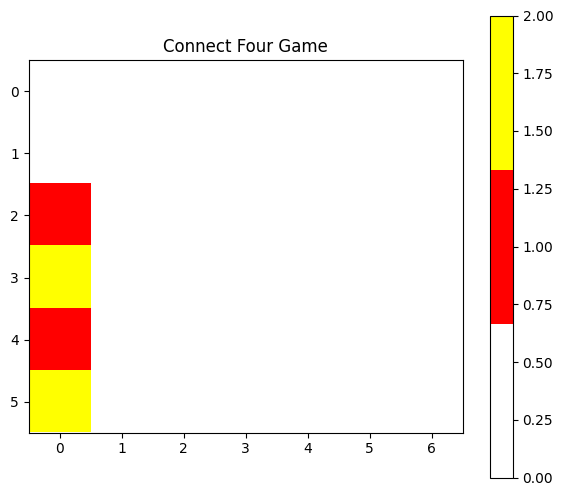

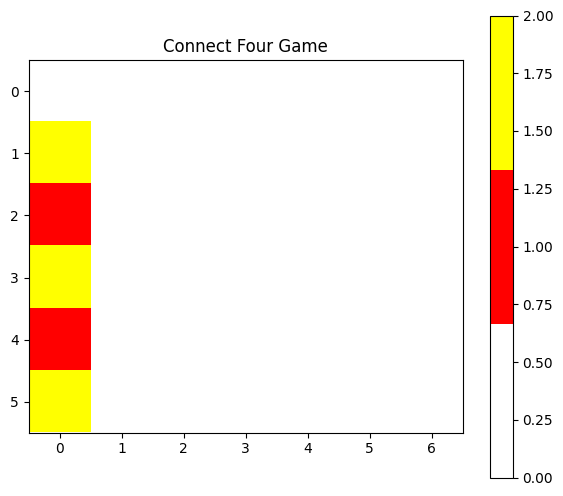

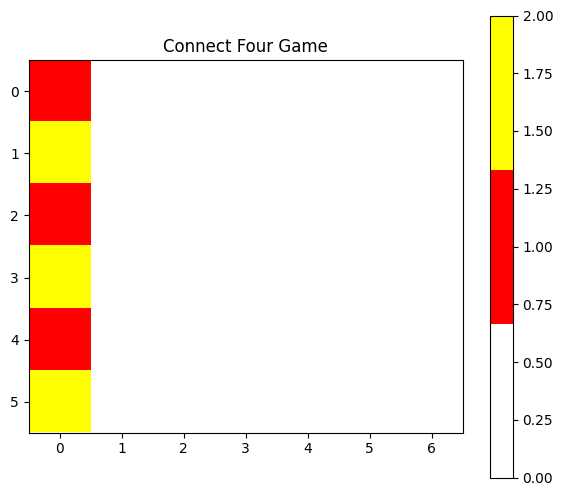

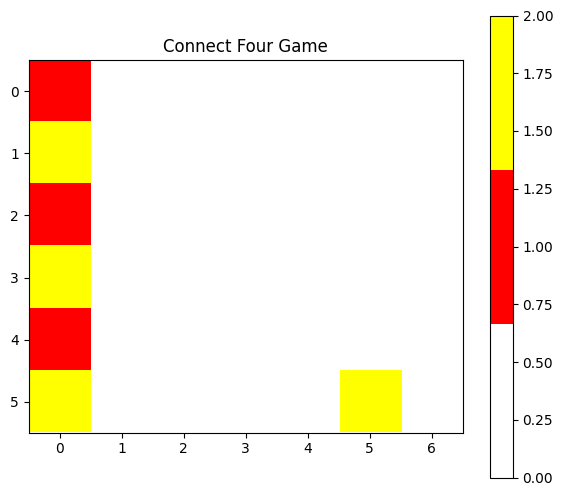

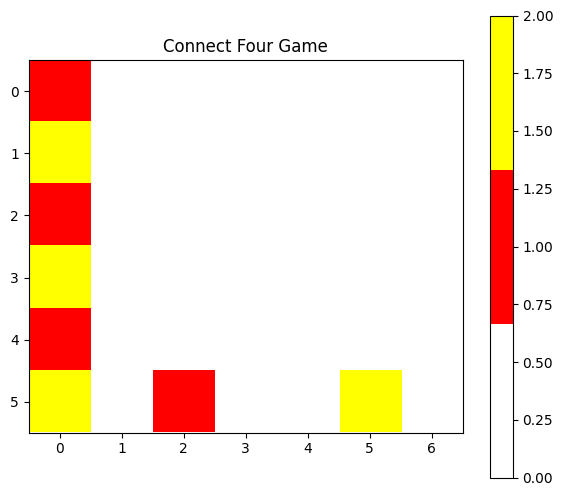

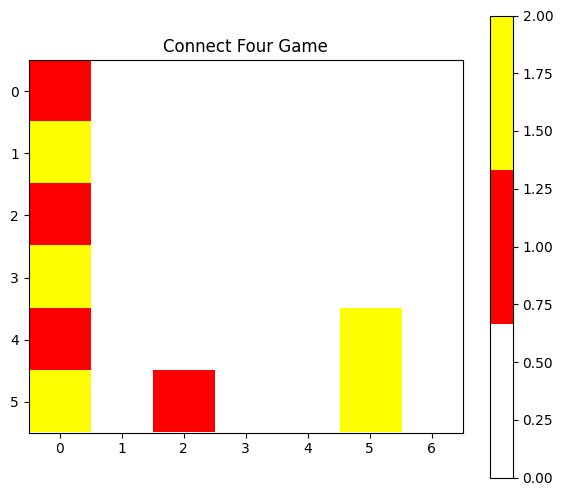

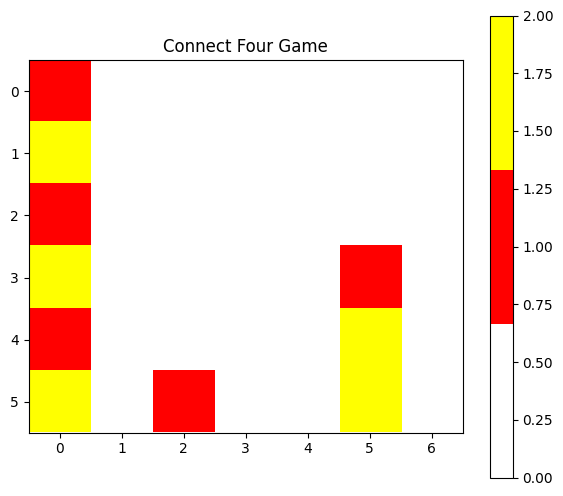

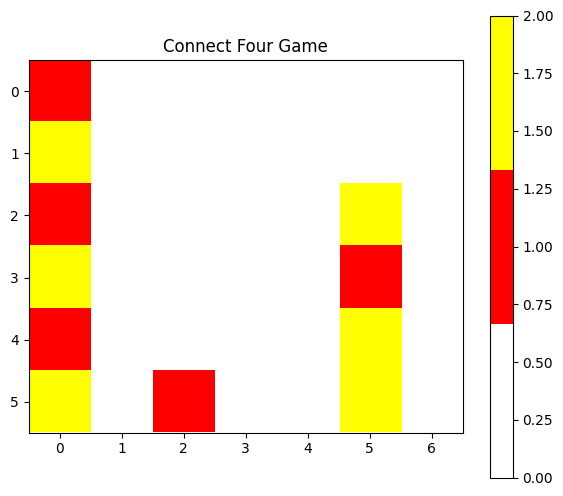

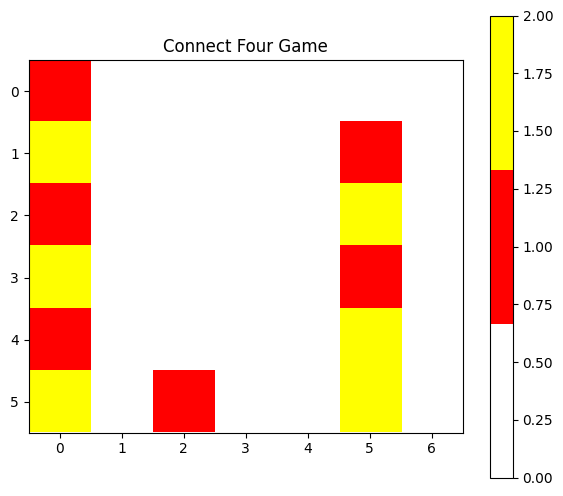

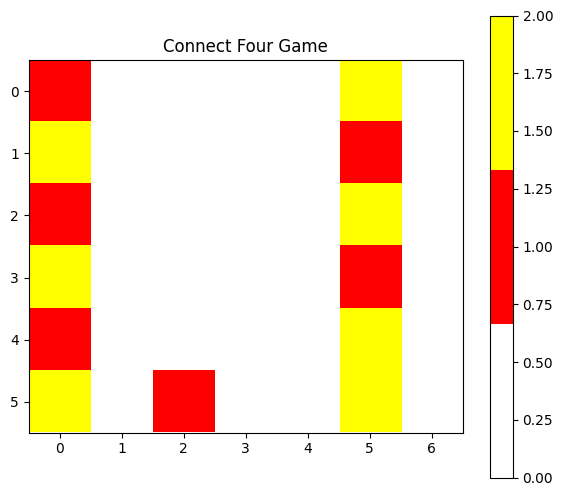

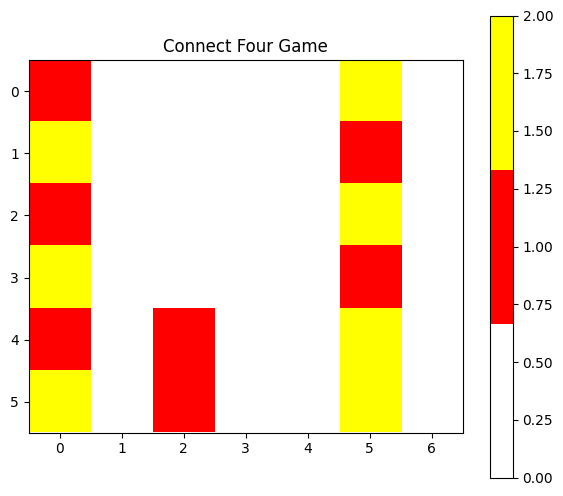

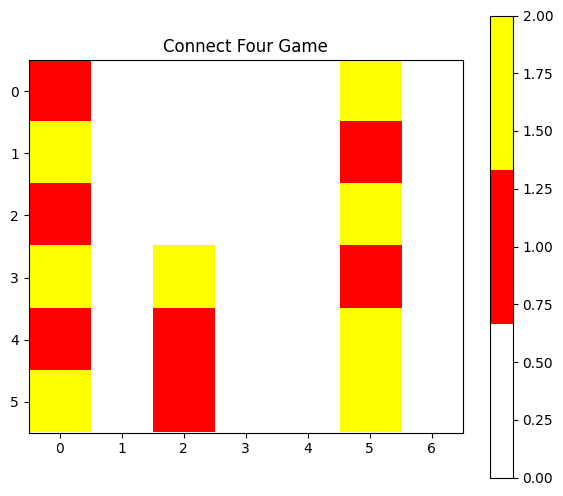

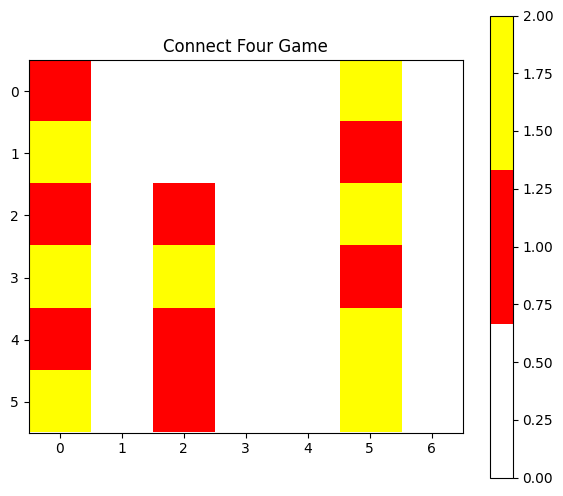

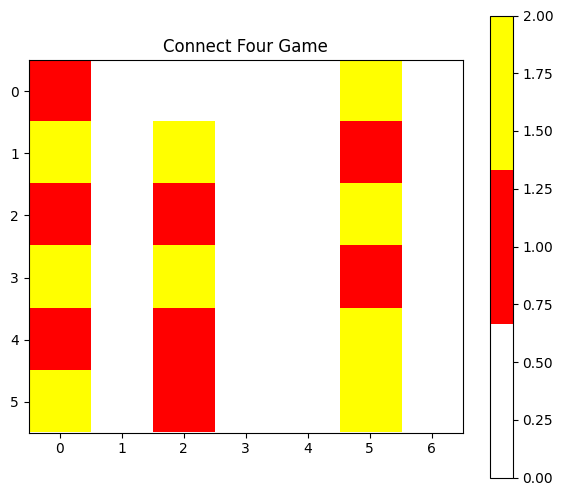

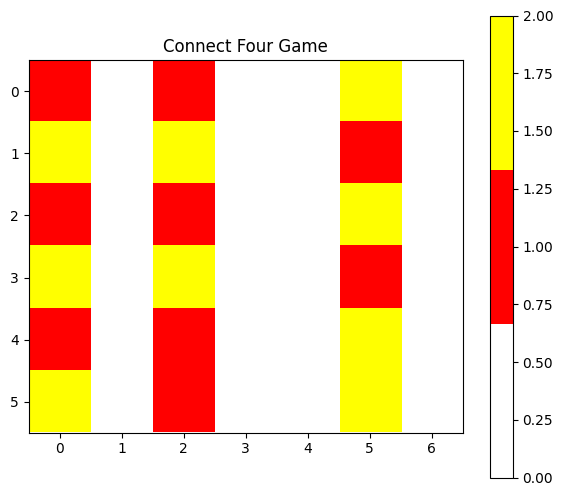

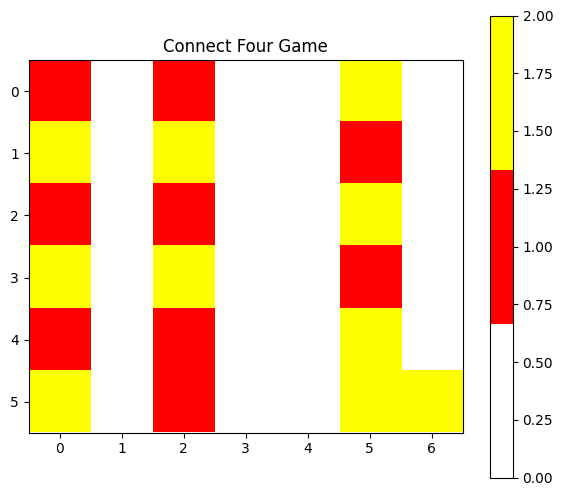

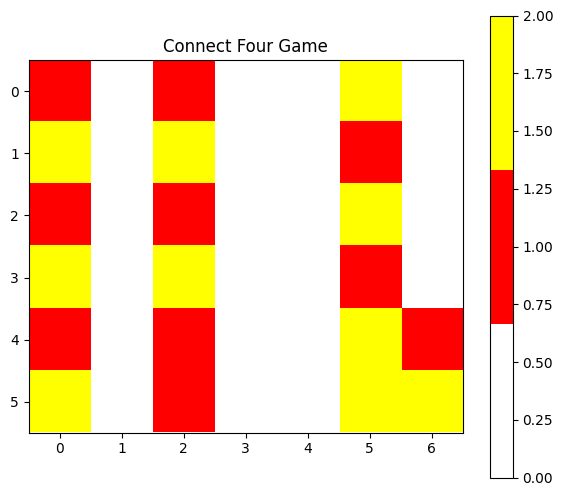

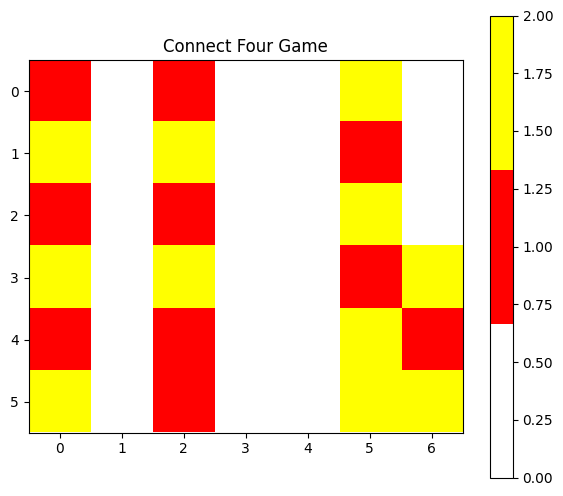

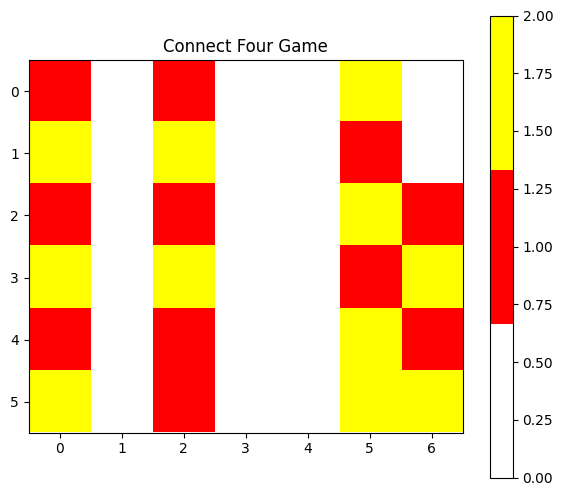

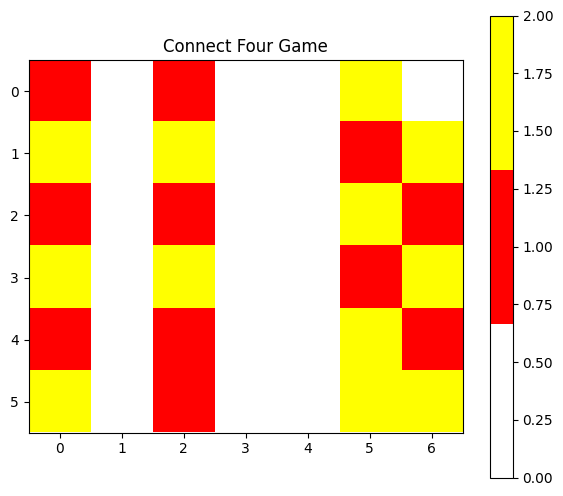

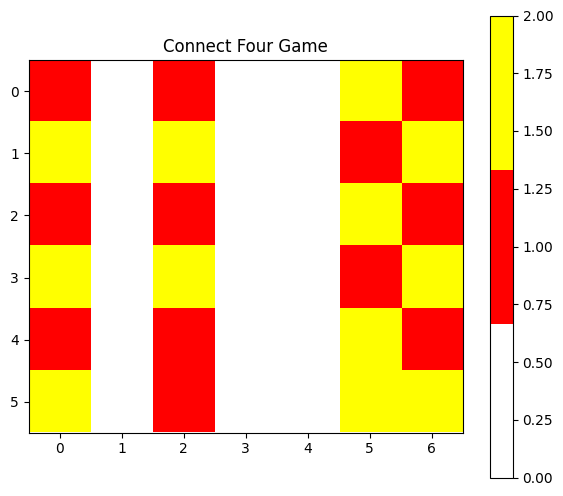

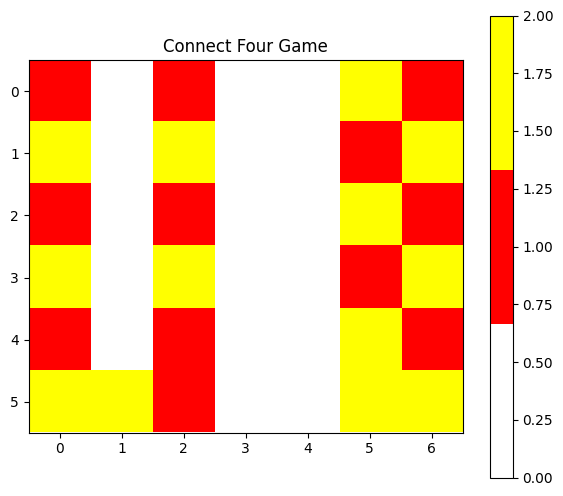

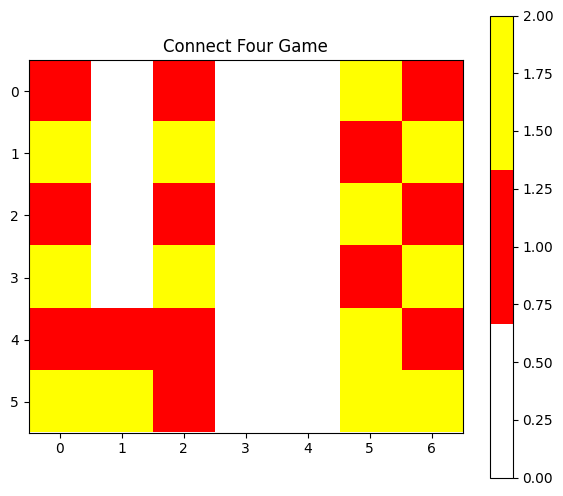

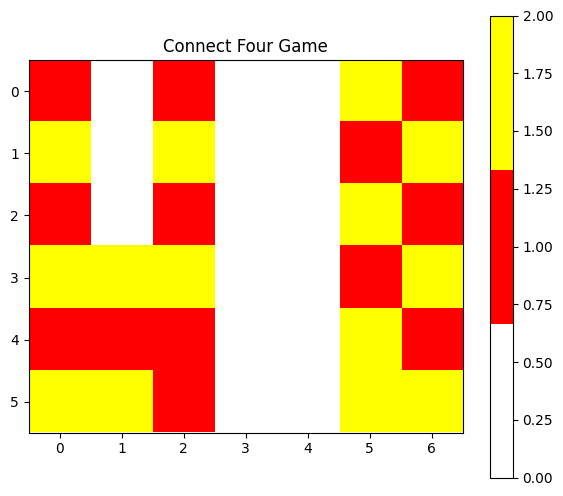

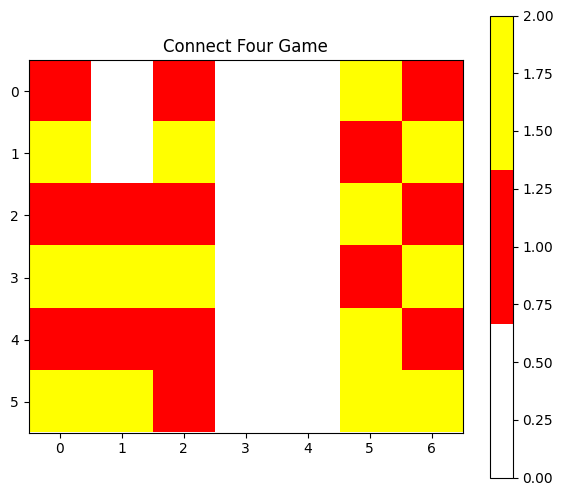

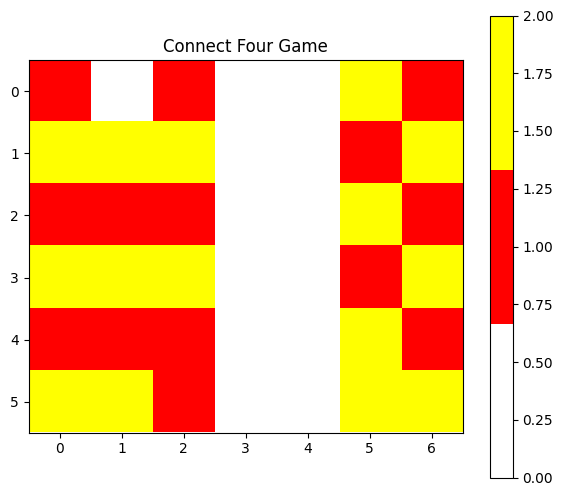

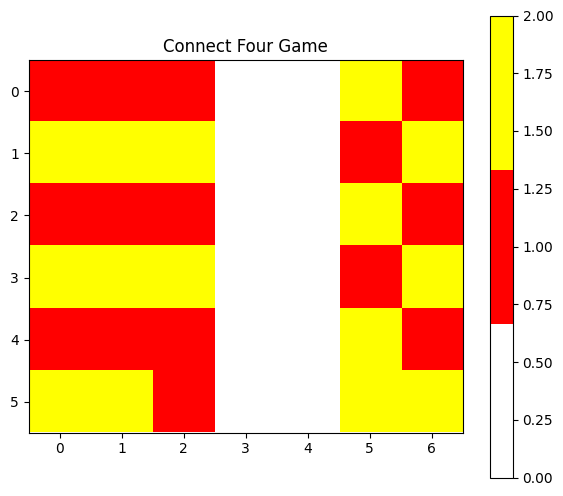

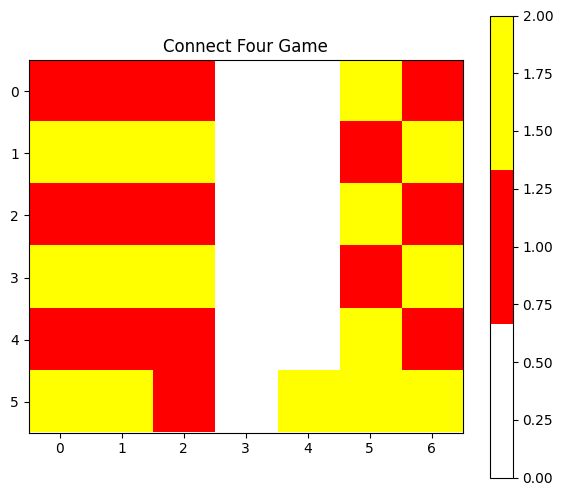

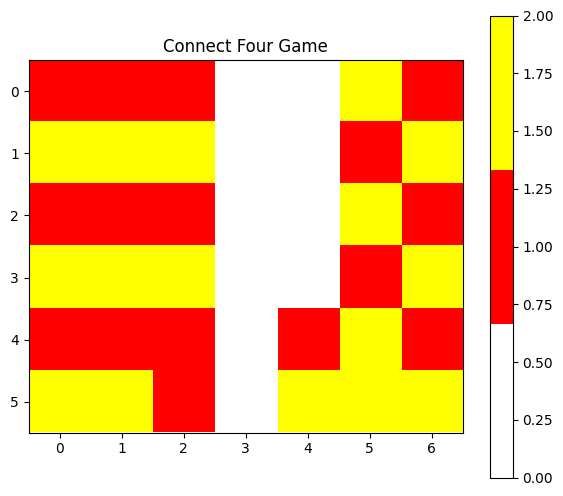

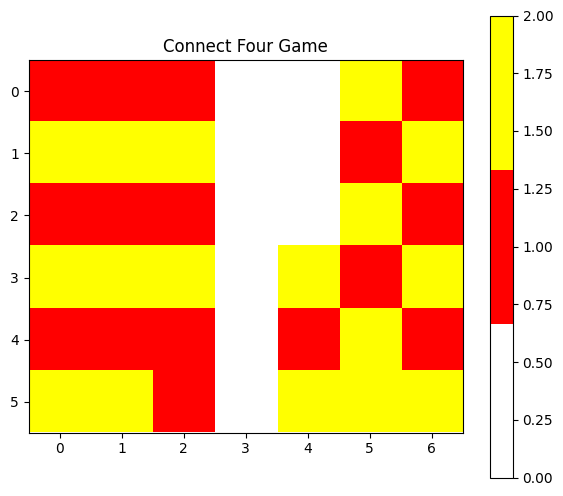

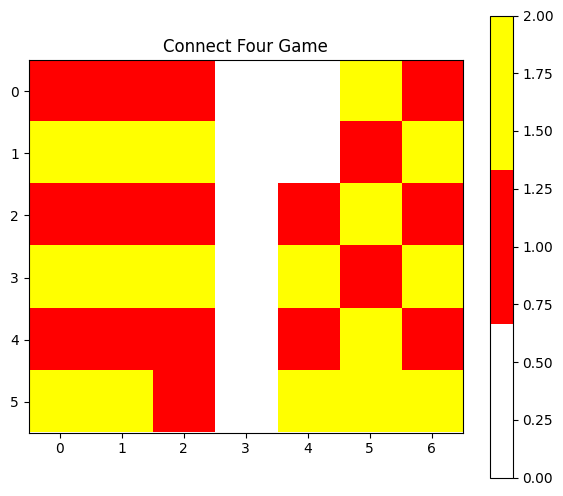

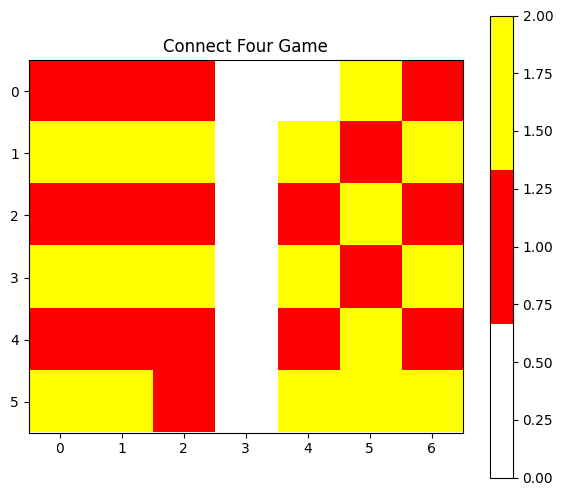

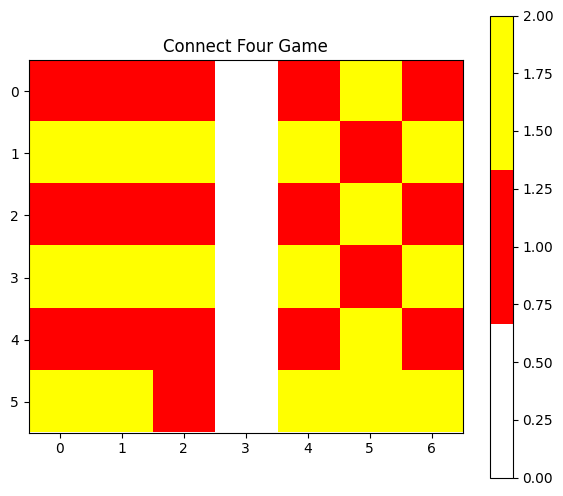

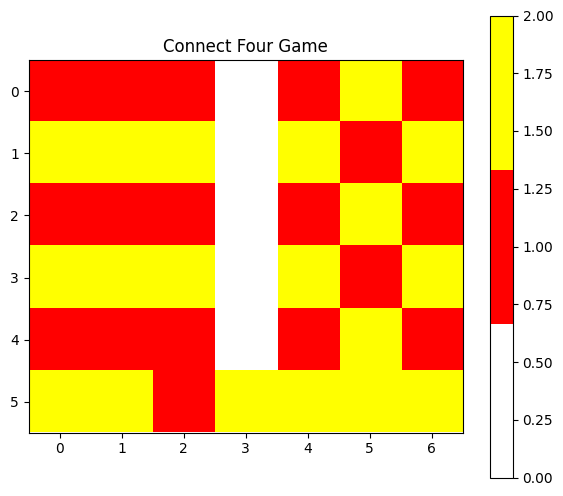

In [9]:
# Test the trained agent
state = env.reset()
done = False
env.render()
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
